In [43]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc07/rr1/724x1024x362/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1024x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/'


filename_prefix = directory+'/shearlayer_'
fname = filename_prefix+'anisotropy.dat'
dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')


Text(0.5,1,'Mc12/rr1/1024x1024x512/')

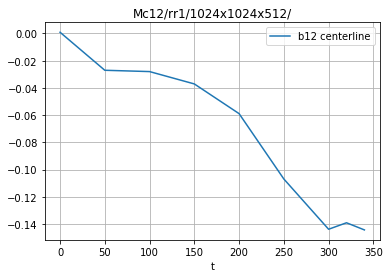

In [44]:
# TKE
n = np.size(dat)

nstats=2
dat = np.reshape(dat,[n/nstats,nstats])
time = dat[:,0]
b12_center = dat[:,1]
# b12_max = dat[:,2]

# Plotting
fig = plt.figure() 
plt.plot(time,b12_center,label='b12 centerline'); 
plt.grid(True)
plt.xlabel('t')
plt.legend()
plt.title(directory.split('/production/')[-1])

Text(0,0.5,'$b_{12}(0)$')

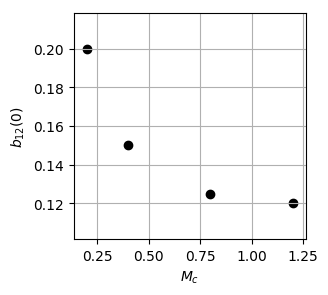

In [52]:
b12 = {
    0.2: 0.20, #256x512
    0.4: 0.15, #256x512
    0.8: 0.125, #512x724
    1.2: 0.12, #724x724
}
fig = plt.figure(figsize=(3,3),dpi=100)
plt.scatter(b12.keys(),b12.values(),c='k')
b12 = {
    0.2: 0.17, #512x724
    0.8: 0.12, #1024x1024
    1.2: 0.14, #1024x1024
}
# plt.scatter(b12.keys(),b12.values())
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$b_{12}(0)$')